In [ ]:
#Install Java Development kit for Spark
!apt-get install openjdk-8-jdk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk is already the newest version (8u265-b01-0ubuntu2~18.04).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [ ]:
import os
#Set the JAVA_HOME env variable
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
#Current working directory
!pwd

/content


In [ ]:
!echo $JAVA_HOME

/usr/lib/jvm/java-8-openjdk-amd64


In [ ]:
#Install PySpark with latest version
!pip install pyspark==3.0.0

In [ ]:
#mount your drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#Create object of spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-pipeline').getOrCreate()

In [ ]:
#Read the csv file
df=spark.read.csv('/content/drive/My Drive/Colab Notebooks/Spark ML/bank.csv',inferSchema=True,header=True)

In [ ]:
df.toPandas().head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [ ]:
#Drop unwanted columns
df = df.drop(*['contact', 'day', 'month','default'])
df.columns

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'deposit']

In [ ]:
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('deposit', 'string')]

In [ ]:
cols = df.columns
cols

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'deposit']

In [ ]:
#create a list of the columns that are string typed
categoricalColumns = [item[0] for item in df.dtypes if item[1].startswith('string') ]
categoricalColumns

['job', 'marital', 'education', 'housing', 'loan', 'poutcome', 'deposit']

In [ ]:
#create a list of the columns that are string typed
numericColumns = [item[0] for item in df.dtypes if item[1].startswith('int') ]
numericColumns

['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

In [ ]:
df.select(numericColumns).describe().toPandas()

,summary,age,balance,duration,campaign,pdays,previous
0,count,11162,11162,11162,11162,11162,11162
1,mean,41.231947679627304,1528.5385235620856,371.99381831213043,2.508421429851281,51.33040673714388,0.8325568894463358
2,stddev,11.913369192215518,3225.413325946149,347.12838571630687,2.7220771816614824,108.75828197197717,2.292007218670508
3,min,18,-6847,2,1,-1,0
4,max,95,81204,3881,63,854,58


In [ ]:
numeric_data = df.select(numericColumns).toPandas()
numeric_data.corr()

,age,balance,duration,campaign,pdays,previous
age,1.000000,0.112300,0.000189,-0.005278,0.002774,0.020169
balance,0.112300,1.000000,0.022436,-0.013894,0.017411,0.030805
duration,0.000189,0.022436,1.000000,-0.041557,-0.027392,-0.026716
campaign,-0.005278,-0.013894,-0.041557,1.000000,-0.102726,-0.049699
pdays,0.002774,0.017411,-0.027392,-0.102726,1.000000,0.507272
previous,0.020169,0.030805,-0.026716,-0.049699,0.507272,1.000000


In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [ ]:
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericColumns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
df.toPandas().head(5)

,label,features,age,job,marital,education,balance,housing,loan,duration,campaign,pdays,previous,poutcome,deposit
0,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59,admin.,married,secondary,2343,yes,no,1042,1,-1,0,unknown,yes
1,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56,admin.,married,secondary,45,no,no,1467,1,-1,0,unknown,yes
2,1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",41,technician,married,secondary,1270,yes,no,1389,1,-1,0,unknown,yes
3,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",55,services,married,secondary,2476,yes,no,579,1,-1,0,unknown,yes
4,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",54,admin.,married,tertiary,184,no,no,673,2,-1,0,unknown,yes


In [ ]:
train_df, test_df = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train_df.count()))
print("Test Dataset Count: " + str(test_df.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train_df)

In [ ]:
lr_summary=lrModel.summary

In [ ]:
#Overall accuracy of the classification model
lr_summary.accuracy

1.0

In [ ]:
#Area under ROC
lr_summary.areaUnderROC

0.999962256621913

In [ ]:
#Precision of both classes
print(lr_summary.precisionByLabel)

[1.0, 1.0]


In [ ]:
#Recall of both classes
print(lr_summary.recallByLabel)

[1.0, 1.0]


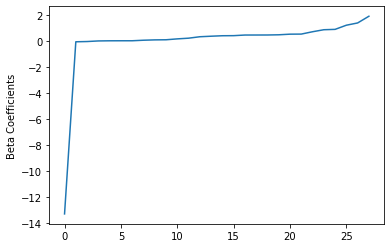

In [ ]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

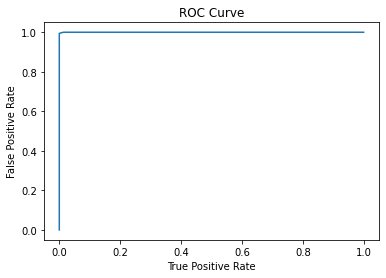

Training set areaUnderROC: 0.999962256621913


In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

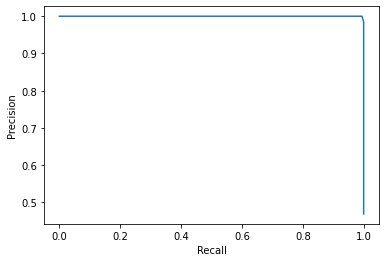

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
predictions = lrModel.transform(test_df)
predictions.select('label','rawPrediction','probability','prediction').toPandas().head(20)
predictions.select('label','prediction').toPandas().head(20)

,label,prediction
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


In [74]:
#Evaluate our Logistic Regression model.
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9999996339023955


In [85]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train_df)
predictions = cvModel.transform(test_df)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9999996339023955


In [86]:
evaluator.getMetricName()

'areaUnderROC'

In [75]:
#Decision Tree Classifier
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train_df)
predictions = dtModel.transform(test_df)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+-------------+----------+-----------+
|age|       job|label|rawPrediction|prediction|probability|
+---+----------+-----+-------------+----------+-----------+
| 31|management|  0.0| [4169.0,0.0]|       0.0|  [1.0,0.0]|
| 40|management|  0.0| [4169.0,0.0]|       0.0|  [1.0,0.0]|
| 42|management|  0.0| [4169.0,0.0]|       0.0|  [1.0,0.0]|
| 42|management|  0.0| [4169.0,0.0]|       0.0|  [1.0,0.0]|
| 50|management|  0.0| [4169.0,0.0]|       0.0|  [1.0,0.0]|
| 52|management|  0.0| [4169.0,0.0]|       0.0|  [1.0,0.0]|
| 56|management|  0.0| [4169.0,0.0]|       0.0|  [1.0,0.0]|
| 44|management|  0.0| [4169.0,0.0]|       0.0|  [1.0,0.0]|
| 46|management|  0.0| [4169.0,0.0]|       0.0|  [1.0,0.0]|
| 54|management|  0.0| [4169.0,0.0]|       0.0|  [1.0,0.0]|
+---+----------+-----+-------------+----------+-----------+
only showing top 10 rows



In [76]:
#Evaluate our Decision Tree model.
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 1.0


In [78]:
#Random Forest Classifier
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train_df)
predictions = rfModel.transform(test_df)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 31|management|  0.0|[17.8118723679305...|       0.0|[0.89059361839652...|
| 40|management|  0.0|[16.1702404689046...|       0.0|[0.80851202344523...|
| 42|management|  0.0|[17.8118723679305...|       0.0|[0.89059361839652...|
| 42|management|  0.0|[16.8065220573523...|       0.0|[0.84032610286761...|
| 50|management|  0.0|[14.7948125853087...|       0.0|[0.73974062926543...|
| 52|management|  0.0|[18.2246493284599...|       0.0|[0.91123246642299...|
| 56|management|  0.0|[18.2246493284599...|       0.0|[0.91123246642299...|
| 44|management|  0.0|[17.8143607462767...|       0.0|[0.89071803731383...|
| 46|management|  0.0|[18.2246493284599...|       0.0|[0.91123246642299...|
| 54|management|  0.0|[18.2246493284599...|       0.0|[0.91123246642299...|
+---+-------

In [79]:
#Evaluate our Decision Tree model.
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 1.0


In [81]:
#Gradient-Boosted Tree Classifier
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train_df)
predictions = gbtModel.transform(test_df)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 31|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 40|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 42|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 42|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 50|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 52|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 56|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 44|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 46|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 54|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
+---+-------

In [82]:
#Evaluate our Gradient-Boosted Tree Classifier.
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 1.0


In [83]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [84]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train_df)
predictions = cvModel.transform(test_df)
evaluator.evaluate(predictions)

1.0